In [127]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import win32com.client

One series data인 KODEX200 price 부터 구해본다. 

추후 scale과 reusability를 고려하여 작성

## df에서 코드 가져오기

In [2]:
kospi_ETF_df = pd.read_pickle('./data_files/kospi_ETF_df.pkl')
kospi_ETF_df.head()

,code,name,stock_control_kind,stock_supervision_kind,stock_status_kind,stock_kospi200_kind,stock_section_kind
686,A069500,KODEX 200,0,0,0,0,10
689,A069660,KOSEF 200,0,0,0,0,10
747,A091160,KODEX 반도체,0,0,0,0,10
748,A091170,KODEX 은행,0,0,0,0,10
749,A091180,KODEX 자동차,0,0,0,0,10


In [3]:
kospi_ETF_df.name

686                     KODEX 200
689                     KOSEF 200
747                     KODEX 반도체
748                      KODEX 은행
749                     KODEX 자동차
                  ...            
1361      KBSTAR KRX국채선물3년10년스티프너
1362    KBSTAR KRX국채선물3년10년스티프너2X
1363      KBSTAR KRX국채선물3년10년플래트너
1364    KBSTAR KRX국채선물3년10년플래트너2X
1366             HANARO KAP초장기국고채
Name: name, Length: 451, dtype: object

In [4]:
code = kospi_ETF_df[kospi_ETF_df.name == 'KODEX 200'].to_numpy()[0][0]
code

'A069500'

## 종목과 조회조건 설정 (Daily data)

In [5]:
instStockChart = win32com.client.Dispatch('CPSysDib.StockChart')

In [46]:
# 종목과 조회조건 등을 설정. 

instStockChart.SetInputValue(0, code) # 첫 인자는 데이터 타입, 두 번째 인자는 입력 데이터 값. 0은 종목코드, A003540은 종목코드. 
instStockChart.SetInputValue(1, ord('2')) # 첫 번째 인자는 기간/요청 설정을 말하는 1. 두 번째 인자는 기간으로 요청 시 1, 개수로 요청시 2. 
instStockChart.SetInputValue(4, 1000) # 첫 번째 인자는 요청개수 설정을 말하는 4. 두 번째 인자는 실제로 몇 개 요청할 것인지 개수. (여기선 10개)
instStockChart.SetInputValue(5, [0, 2, 3, 4, 5, 8]) # 첫 번째 인자는 요청할 데이터의 종류를 말하는 5. 두 번째 인자는 어떤 인자를 요청할 지. 5는 종가. 
instStockChart.SetInputValue(6, ord('D')) # 첫 번째 인자는 차트의 종류를 말하는 6. 두 번째 인자는 어떤 차트인지. ord('D')는 일단위
instStockChart.SetInputValue(9, ord('1')) # 첫 번째 인자는 수정주가의 반영여부를 말하는 9, 두 번째 인자는 수정주가를 의미하는 ord('1')

In [47]:
instStockChart.BlockRequest()

0

In [48]:
print("""
Header information

Ticker: {ticker}
Field names: {field_names}
Data count: {data_count}
""".format(
    ticker=instStockChart.GetHeaderValue(0),
    field_names=instStockChart.GetHeaderValue(2),
    data_count=instStockChart.GetHeaderValue(3),
))



Header information

Ticker: A069500
Field names: ('날짜', '시가', '고가', '저가', '종가', '거래량')
Data count: 1000



In [49]:
data_count = instStockChart.GetHeaderValue(3)
fields_count = instStockChart.GetHeaderValue(1)
print(data_count, fields_count)

1000 6


In [50]:
kodex200_d = []

for i in range(data_count):
    date = instStockChart.GetDataValue(0, i)
    open_price = instStockChart.GetDataValue(1, i)
    high_price = instStockChart.GetDataValue(2, i)
    low_price = instStockChart.GetDataValue(3, i)
    close_price = instStockChart.GetDataValue(4, i)
    volume = instStockChart.GetDataValue(5, i)
    
    row_dic = {}
    row_dic['date'] = date
    row_dic['open'] = open_price
    row_dic['high'] = high_price
    row_dic['low'] = low_price
    row_dic['close'] = close_price
    row_dic['volume'] = volume
    
    kodex200_d.append(row_dic)

In [51]:
# TODO: 변수 네이밍 바꿔주자 _df 붙일 대상 정하고 time series와 아닌것 구분

kodex200_ts_d_df = pd.DataFrame(kodex200_d)
kodex200_ts_d_df.head()

,date,open,high,low,close,volume
0,20200130,29695,29765,29250,29260,3858197
1,20200129,29764,29889,29585,29735,2968338
2,20200128,29849,30004,29485,29635,8162182
3,20200123,30768,30808,30538,30563,5616217
4,20200122,30498,30997,30483,30967,6071067


In [52]:
kodex200_ts_d_df.date = pd.to_datetime(kodex200_ts_d_df.date, format='%Y%m%d')
kodex200_ts_d_df = kodex200_ts_d_df.set_index('date')
kodex200_ts_d_df.head()

,open,high,low,close,volume
date,,,,,
2020-01-30,29695,29765,29250,29260,3858197
2020-01-29,29764,29889,29585,29735,2968338
2020-01-28,29849,30004,29485,29635,8162182
2020-01-23,30768,30808,30538,30563,5616217
2020-01-22,30498,30997,30483,30967,6071067


In [53]:
kodex200_ts_d_df.to_pickle('./data_files/kodex200_ts_d_df.pkl')

In [128]:
kodex200_ts_d_df.index

DatetimeIndex(['2020-01-30', '2020-01-29', '2020-01-28', '2020-01-23',
               '2020-01-22', '2020-01-21', '2020-01-20', '2020-01-17',
               '2020-01-16', '2020-01-15',
               ...
               '2016-01-13', '2016-01-12', '2016-01-11', '2016-01-08',
               '2016-01-07', '2016-01-06', '2016-01-05', '2016-01-04',
               '2015-12-30', '2015-12-29'],
              dtype='datetime64[ns]', name='date', length=1000, freq=None)

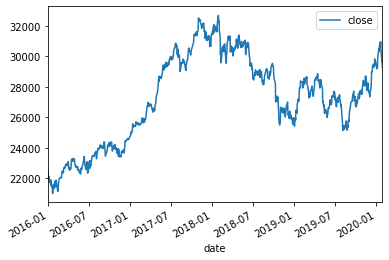

In [130]:
kodex200_ts_d_df.plot(y='close')

## Minute data 얻기. (tick은 너무 작으니까.)

minute은 time필드가 추가된다. (%H%M)

In [54]:
# 종목과 조회조건 등을 설정. 

instStockChart.SetInputValue(0, code) # 첫 인자는 데이터 타입, 두 번째 인자는 입력 데이터 값. 0은 종목코드, A003540은 종목코드. 
instStockChart.SetInputValue(1, ord('2')) # 첫 번째 인자는 기간/요청 설정을 말하는 1. 두 번째 인자는 기간으로 요청 시 1, 개수로 요청시 2. 
instStockChart.SetInputValue(4, 1000) # 첫 번째 인자는 요청개수 설정을 말하는 4. 두 번째 인자는 실제로 몇 개 요청할 것인지 개수. (여기선 10개)
instStockChart.SetInputValue(5, [0, 1, 2, 3, 4, 5, 8]) # 첫 번째 인자는 요청할 데이터의 종류를 말하는 5. 두 번째 인자는 어떤 인자를 요청할 지. 5는 종가. 
instStockChart.SetInputValue(6, ord('m')) # 첫 번째 인자는 차트의 종류를 말하는 6. 두 번째 인자는 어떤 차트인지. ord('D')는 일단위
instStockChart.SetInputValue(9, ord('1')) # 첫 번째 인자는 수정주가의 반영여부를 말하는 9, 두 번째 인자는 수정주가를 의미하는 ord('1')

In [55]:
instStockChart.BlockRequest()

0

In [56]:
print("""
Header information

Ticker: {ticker}
Field names: {field_names}
Data count: {data_count}
""".format(
    ticker=instStockChart.GetHeaderValue(0),
    field_names=instStockChart.GetHeaderValue(2),
    data_count=instStockChart.GetHeaderValue(3),
))



Header information

Ticker: A069500
Field names: ('날짜', '시간', '시가', '고가', '저가', '종가', '거래량')
Data count: 1000



In [57]:
data_count = instStockChart.GetHeaderValue(3)
fields_count = instStockChart.GetHeaderValue(1)
print(data_count, fields_count)

1000 7


In [58]:
kodex200_m = []

for i in range(data_count):
    date = instStockChart.GetDataValue(0, i)
    time = instStockChart.GetDataValue(1, i)
    open_price = instStockChart.GetDataValue(2, i)
    high_price = instStockChart.GetDataValue(3, i)
    low_price = instStockChart.GetDataValue(4, i)
    close_price = instStockChart.GetDataValue(5, i)
    volume = instStockChart.GetDataValue(6, i)
    
    row_dic = {}
    row_dic['date'] = date
    row_dic['time'] = time
    row_dic['open'] = open_price
    row_dic['high'] = high_price
    row_dic['low'] = low_price
    row_dic['close'] = close_price
    row_dic['volume'] = volume
    
    kodex200_m.append(row_dic)

In [120]:
# TODO: 변수 네이밍 바꿔주자 _df 붙일 대상 정하고 time series와 아닌것 구분

kodex200_ts_m_df = pd.DataFrame(kodex200_m)
kodex200_ts_m_df.head()

,date,time,open,high,low,close,volume
0,20200130,1358,29270,29270,29260,29270,1706
1,20200130,1357,29275,29275,29260,29260,9240
2,20200130,1356,29280,29285,29265,29270,8952
3,20200130,1355,29285,29290,29280,29280,2566
4,20200130,1354,29285,29295,29285,29290,3681


In [121]:
kodex200_ts_m_df.tail()

,date,time,open,high,low,close,volume
995,20200128,1005,29804,29814,29794,29809,11647
996,20200128,1004,29794,29804,29794,29804,14493
997,20200128,1003,29789,29804,29789,29799,20806
998,20200128,1002,29779,29789,29759,29789,25290
999,20200128,1001,29749,29774,29739,29769,19646


In [122]:
kodex200_ts_m_df.describe() # time format 형식 알아내기 위해. zero-padded 되지 않은 %H%M 형식.

,date,time,open,high,low,close,volume
count,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,2.020013e+07,1194.641000,29642.391000,29649.85600,29634.236000,29642.172000,13113.796000
std,7.868228e-01,169.415471,161.100669,160.60759,161.499977,161.395784,20279.182348
min,2.020013e+07,901.000000,29255.000000,29260.00000,29250.000000,29255.000000,100.000000
25%,2.020013e+07,1044.000000,29560.000000,29570.00000,29550.000000,29560.000000,2907.750000
50%,2.020013e+07,1207.000000,29630.000000,29640.00000,29625.000000,29630.000000,6739.000000
75%,2.020013e+07,1330.250000,29784.000000,29789.00000,29779.000000,29784.000000,16555.750000
max,2.020013e+07,1530.000000,29884.000000,29889.00000,29874.000000,29889.000000,264534.000000


In [123]:
kodex200_ts_m_df.date = pd.to_datetime(kodex200_ts_m_df.date, format='%Y%m%d')
kodex200_ts_m_df.time = pd.to_datetime(kodex200_ts_m_df.time, format='%H%M').dt.time
kodex200_ts_m_df.head()

,date,time,open,high,low,close,volume
0,2020-01-30,13:58:00,29270,29270,29260,29270,1706
1,2020-01-30,13:57:00,29275,29275,29260,29260,9240
2,2020-01-30,13:56:00,29280,29285,29265,29270,8952
3,2020-01-30,13:55:00,29285,29290,29280,29280,2566
4,2020-01-30,13:54:00,29285,29295,29285,29290,3681


In [124]:
kodex200_ts_m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
date      1000 non-null datetime64[ns]
time      1000 non-null object
open      1000 non-null int64
high      1000 non-null int64
low       1000 non-null int64
close     1000 non-null int64
volume    1000 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 50.8+ KB


date와 time의 type이 일치하지 않는다. 둘 다 str으로 바꾼 뒤 합쳐 다시 datetime으로 파싱시키겠다.

In [125]:
kodex200_ts_m_df['datetime'] = pd.to_datetime(kodex200_ts_m_df.date.astype(str) + ' ' + kodex200_ts_m_df.time.astype(str))
kodex200_ts_m_df = kodex200_ts_m_df.drop(['date', 'time'], axis=1)
kodex200_ts_m_df = kodex200_ts_m_df.set_index('datetime')
kodex200_ts_m_df.head()

,open,high,low,close,volume
datetime,,,,,
2020-01-30 13:58:00,29270,29270,29260,29270,1706
2020-01-30 13:57:00,29275,29275,29260,29260,9240
2020-01-30 13:56:00,29280,29285,29265,29270,8952
2020-01-30 13:55:00,29285,29290,29280,29280,2566
2020-01-30 13:54:00,29285,29295,29285,29290,3681


In [126]:
kodex200_ts_m_df.to_pickle('./data_files/kodex200_ts_m_df.pkl')

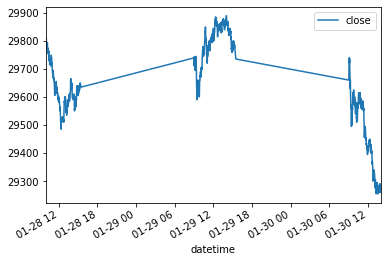

In [131]:
kodex200_ts_m_df.plot(y='close')